In [1]:
import numpy as np
import pandas as pd
import pandas_gbq

import tensorflow as tf
# import tensorflow_decision_forests as tfdf

from IPython.display import clear_output
from matplotlib import pyplot as plt

In [2]:
# Load datasets
sql = "SELECT * FROM kubeflow-1-0-2.credit_card_fraud.train"
dftrain = pd.read_gbq(sql)

sql = "SELECT * FROM kubeflow-1-0-2.credit_card_fraud.validation"
dfeval = pd.read_gbq(sql)

In [3]:
dftrain.head()

,TransactionDT,TransactionAmt,card1,card2,card3,C1,C2,C11,C12,C13,C14,D8,V45,V87,V258,card6,ProductCD,emaildomain,isFraud
0,15029930,300.000,2560,562.0,150.0,1475.0,1637.0,1183.0,0.0,833.0,779.0,846.916687,0.0,0.0,0.0,credit,R,gmail.com,0
1,4242713,77.592,11520,399.0,150.0,39.0,323.0,83.0,83.0,149.0,19.0,0.000000,2.0,3.0,0.0,credit,C,anonymous.com,1
2,1972350,250.000,12544,321.0,150.0,1184.0,1297.0,933.0,0.0,689.0,637.0,71.791664,0.0,0.0,0.0,debit,R,gmail.com,0
3,14132532,200.000,12544,321.0,150.0,1446.0,1603.0,1155.0,0.0,817.0,761.0,85.541664,0.0,0.0,0.0,debit,R,gmail.com,0
4,13798278,75.000,12544,321.0,150.0,1419.0,1568.0,1130.0,0.0,809.0,752.0,81.666664,0.0,0.0,0.0,debit,R,msn.com,0


In [4]:
dftrain.shape

(115368, 19)

In [5]:
y_train = dftrain.pop('isFraud')
y_eval = dfeval.pop('isFraud')

In [6]:
dftrain.dtypes

TransactionDT       int64
TransactionAmt    float64
card1               int64
card2             float64
card3             float64
C1                float64
C2                float64
C11               float64
C12               float64
C13               float64
C14               float64
D8                float64
V45               float64
V87               float64
V258              float64
card6              object
ProductCD          object
emaildomain        object
dtype: object

In [7]:
dftrain.columns.to_list()

['TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'C1',
 'C2',
 'C11',
 'C12',
 'C13',
 'C14',
 'D8',
 'V45',
 'V87',
 'V258',
 'card6',
 'ProductCD',
 'emaildomain']

In [8]:
NUMERIC_COLUMNS = ['TransactionDT', 'TransactionAmt',
                   'card1', 'card2', 'card3', 
                   'C1', 'C2', 'C11', 'C12', 'C13', 'C14',
                   'D8',
                   'V45', 'V87', 'V258']

CATEGORICAL_COLUMNS = ['card6', 'ProductCD', 'emaildomain']

def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
                tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                                          vocab)
                                             )

In [9]:
feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name,
                                              vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                                            dtype=tf.float32))

In [10]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y,
                  n_epochs=None,
                  shuffle=True):  # only for training set
    
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    
    return input_fn

In [11]:
# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)

eval_input_fn = make_input_fn(dfeval, y_eval,
                              shuffle=False,  # not to shuffle test set
                              n_epochs=3)

Logistic regression model in TensorFlow

In [12]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)
clear_output()

print(pd.Series(result))

accuracy                    0.923645
accuracy_baseline           0.923645
auc                         0.500000
auc_precision_recall        0.076355
average_loss            21341.796875
label/mean                  0.076355
loss                    21341.796875
precision                   0.000000
prediction/mean             0.000000
recall                      0.000000
global_step               100.000000
dtype: float64


Loss is weird. AUC=0.5; precision = recall = 0?
Accuracy is hardly any better than random guess because our dataset is quite imbalanced, remember?

Probably a linear model (like LR algorithm) is too simple for this problem/data (which might be having relatively higher complexity). Let's validate this by increasing the model complexity.

Boosted trees implmentation in TensorFlow

In [13]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()

print(pd.Series(result))

accuracy                  0.960263
accuracy_baseline         0.923645
auc                       0.940103
auc_precision_recall      0.765012
average_loss              0.124008
label/mean                0.076355
loss                      0.124008
precision                 0.871921
prediction/mean           0.076882
recall                    0.562160
global_step             100.000000
dtype: float64


Looks relatively much better now :)

Plotting probabilities of predictions

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplbud88g6/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


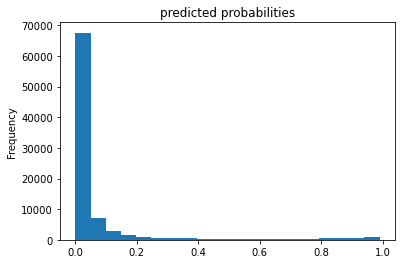

In [14]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist',
           bins=20,
           title='predicted probabilities')
plt.show()

Note: Model does not seem confident at all, in most of its predictions. Red flag?

Reference for original tutorial: https://www.tensorflow.org/tutorials/estimator/boosted_trees

Another option worth trying seems to be 'Decision Forests in TF'

Reference: https://www.tensorflow.org/decision_forests